<a href="https://colab.research.google.com/github/antonsysoev/ktmi_pm/blob/%D0%9F%D0%9C-19/%D0%9B%D0%B5%D0%BA%D1%86%D0%B8%D1%8F%204%20(2022)%20Linear_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [3]:
%%R
install.packages("outliers")
install.packages("EnvStats")
install.packages("car")
install.packages("leaps")
install.packages("bootstrap")
install.packages("glmnet")
install.packages("psych")
install.packages("caret")

library(outliers)
library(EnvStats)
library(car)
library(MASS)
library(leaps)
library(bootstrap)
library(glmnet)  
library(dplyr)  
library(psych)  
library(caret)

(as ‘lib’ is unspecified)







	‘/tmp/RtmpCiFApH/downloaded_packages’

(as ‘lib’ is unspecified)














	‘/tmp/RtmpCiFApH/downloaded_packages’

(as ‘lib’ is unspecified)















































































	‘/tmp/RtmpCiFApH/downloaded_packages’

(as ‘lib’ is unspecified)







	‘/tmp/RtmpCiFApH/downloaded_packages’

(as ‘lib’ is unspecified)







	‘/tmp/RtmpCiFApH/downloaded_packages’

(as ‘lib’ is unspecified)
























	‘/tmp/RtmpCiFApH/downloaded_packages’

(as ‘lib’ is unspecified)














	‘/tmp/RtmpCiFApH/downloaded_packages’

(as ‘lib’ is unspecified)













































































































	‘/tmp/RtmpCiFApH/downloaded_packages’

Attaching package: ‘EnvStats’



    predict, predict.lm



    print.default



Attaching package: ‘car’



    qqPlot


Attaching package: ‘MASS’



    boxcox




Attaching package: ‘dplyr’



    select



 

**Корректировка моделей**


Необычные наблюдения требуют отдельного изучения: либо потому, что они каким-то образом отличаются от прочих, либо потому, что они значительно влияют на общие результаты.

*Выбросы* 

Характеризуются большими положительными или отрицательными остатками $\hat{Y_i} - Y_i$. Положительные остатки свидетельствуют о том, что модель недооценивает зависимую переменную, отрицательные остатки - признак переоценки.

In [4]:
%%R
summary(state.x77) # датасет о штатах США
df <- state.x77
colnames(df)[4]  <- 'Life_Exp'
df <- as.data.frame(df)


In [5]:
%%R
summary(df)

   Population        Income       Illiteracy       Life_Exp    
 Min.   :  365   Min.   :3098   Min.   :0.500   Min.   :67.96  
 1st Qu.: 1080   1st Qu.:3993   1st Qu.:0.625   1st Qu.:70.12  
 Median : 2838   Median :4519   Median :0.950   Median :70.67  
 Mean   : 4246   Mean   :4436   Mean   :1.170   Mean   :70.88  
 3rd Qu.: 4968   3rd Qu.:4814   3rd Qu.:1.575   3rd Qu.:71.89  
 Max.   :21198   Max.   :6315   Max.   :2.800   Max.   :73.60  
     Murder          HS Grad          Frost             Area       
 Min.   : 1.400   Min.   :37.80   Min.   :  0.00   Min.   :  1049  
 1st Qu.: 4.350   1st Qu.:48.05   1st Qu.: 66.25   1st Qu.: 36985  
 Median : 6.850   Median :53.25   Median :114.50   Median : 54277  
 Mean   : 7.378   Mean   :53.11   Mean   :104.46   Mean   : 70736  
 3rd Qu.:10.675   3rd Qu.:59.15   3rd Qu.:139.75   3rd Qu.: 81162  
 Max.   :15.100   Max.   :67.30   Max.   :188.00   Max.   :566432  


Статистические тесты для определения выбросов:

1. Тест Граббса

Тест Граббса позволяет определить, является ли самое большое или самое малое значение в наборе данных выбросом.

Тест Граббса выявляет один выброс за раз (наибольшее или наименьшее значение), поэтому нулевая и альтернативная гипотезы выглядят следующим образом: 

$H_0:$ Наибольшее значение не является выбросом

$H_1:$ Наибольшее значение является выбросом

если мы хотим проверить наибольшее значение, или:

$H_0:$ Наименьшее значение не является выбросом

$H_1:$ Наименьшее значение является выбросом

если мы хотим проверить наименьшее значение.

Как и для любого статистического теста, если $p$-значение меньше выбранного порога значимости (обычно $α=0,05$), то нулевая гипотеза отвергается, и мы приходим к выводу, что наибольшее/наименьшее значение является выбросом. Напротив, если $p$-значение больше или равно уровню значимости, нулевая гипотеза не отвергается, и мы приходим к выводу, что на основании данных мы не отвергаем гипотезу о том, что наименьшее/наибольшее значение не является выбросом.

Обратите внимание, что тест Граббса не подходит для выборки размером 6 или менее ($n \le 6$).

Для выполнения теста Граббса в R мы используем функцию grubbs.test() из пакета {outliers}:

In [6]:
%%R

grubbs <- grubbs.test(df$Population, opposite = FALSE)
grubbs


	Grubbs test for one outlier

data:  df$Population
G = 3.79698, U = 0.69977, p-value = 0.0009524
alternative hypothesis: highest value 21198 is an outlier



2. Тест Диксона

Обратите внимание, что тест Диксона наиболее полезен при небольшом размере выборки (обычно $n \le 25$).

Для выполнения теста Диксона в R мы используем функцию dixon.test() из пакета {outliers}. Однако мы ограничиваем наш набор данных 20 первыми наблюдениями, так как тест Диксона может быть выполнен только для небольшого размера выборки (R выдаст ошибку и примет только набор данных от 3 до 30 наблюдений):

In [7]:
%%R

df_small <- df$Population[1:20]
dixon <- dixon.test(df_small)
dixon


	Dixon test for outliers

data:  df_small
Q = 0.63385, p-value < 2.2e-16
alternative hypothesis: highest value 21198 is an outlier



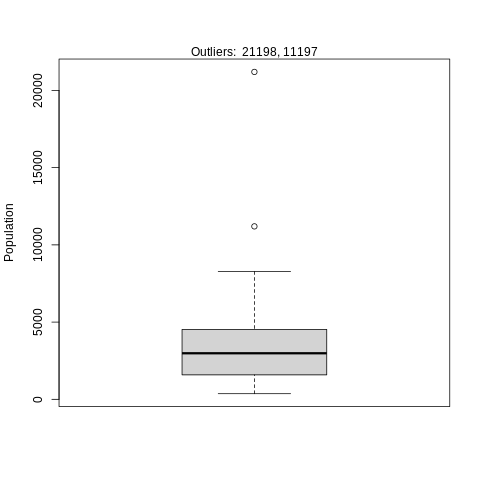

In [8]:
%%R

out <- boxplot.stats(df_small)$out
boxplot(df_small,
  ylab = "Population"
)
mtext(paste("Outliers: ", paste(out, collapse = ", ")))

3. Тест Рознера

Тест Рознера на выбросы имеет следующие преимущества:

* он используется для обнаружения нескольких выбросов одновременно (в 
отличие от теста Граббса и Диксона, который должен выполняться итеративно для отбора нескольких выбросов), и
* он разработан таким образом, чтобы избежать проблемы маскировки, когда выброс, близкий по значению к другому выбросу, может остаться незамеченным.

Для выполнения теста Рознера мы используем функцию rosnerTest() из пакета {EnvStats}. Эта функция требует как минимум 2 аргумента: данные и число предполагаемых выбросов $k$ (по умолчанию $k = 3$).

In [9]:
%%R
rosner <- rosnerTest(df$Population, k = 10)
rosner

$distribution
[1] "Normal"

$statistic
     R.1      R.2      R.3      R.4      R.5      R.6      R.7      R.8 
3.796979 3.756750 2.705845 2.853780 2.941495 3.128699 2.854329 2.793984 
     R.9     R.10 
2.617622 1.995832 

$sample.size
[1] 50

$parameters
 k 
10 

$alpha
[1] 0.05

$crit.value
 lambda.1  lambda.2  lambda.3  lambda.4  lambda.5  lambda.6  lambda.7  lambda.8 
 3.128247  3.120128  3.111796  3.103243  3.094456  3.085425  3.076135  3.066572 
 lambda.9 lambda.10 
 3.056723  3.046571 

$n.outliers
[1] 6

$alternative
[1] "Up to 10 observations are not\n                                 from the same Distribution."

$method
[1] "Rosner's Test for Outliers"

$data
 [1]  3615   365  2212  2110 21198  2541  3100   579  8277  4931   868   813
[13] 11197  5313  2861  2280  3387  3806  1058  4122  5814  9111  3921  2341
[25]  4767   746  1544   590   812  7333  1144 18076  5441   637 10735  2715
[37]  2284 11860   931  2816   681  4173 12237  1203   472  4981  3559  1799
[49]  4589   

4. В пакете car также реализован статистический тест на выбросы. Функция outlierTest() вычисляет значение вероятности статистической ошибки первого
рода с поправкой Бонферрони для наибольшего остатка Стьюдента

In [10]:
%%R
linear_model <- lm(Life_Exp ~., df)
summary(linear_model)


Call:
lm(formula = Life_Exp ~ ., data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.48895 -0.51232 -0.02747  0.57002  1.49447 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  7.094e+01  1.748e+00  40.586  < 2e-16 ***
Population   5.180e-05  2.919e-05   1.775   0.0832 .  
Income      -2.180e-05  2.444e-04  -0.089   0.9293    
Illiteracy   3.382e-02  3.663e-01   0.092   0.9269    
Murder      -3.011e-01  4.662e-02  -6.459 8.68e-08 ***
`HS Grad`    4.893e-02  2.332e-02   2.098   0.0420 *  
Frost       -5.735e-03  3.143e-03  -1.825   0.0752 .  
Area        -7.383e-08  1.668e-06  -0.044   0.9649    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.7448 on 42 degrees of freedom
Multiple R-squared:  0.7362,	Adjusted R-squared:  0.6922 
F-statistic: 16.74 on 7 and 42 DF,  p-value: 2.534e-10



In [11]:
%%R
outlierTest(linear_model)

No Studentized residuals with Bonferroni p < 0.05
Largest |rstudent|:
       rstudent unadjusted p-value Bonferroni p
Hawaii 2.735242          0.0091673      0.45837


*Точки высокой напряженности*

Точки с высокой напряженностью – это выбросы в отношении других независимых пе-
ременных. Они характеризуются необычным сочетанием значений независимых переменных. Значение зависимой переменной не используется при вычислении напряженности. Идентифицируются при помощи показателя влияния (hat statisctic). 

Для определенного набора данных среднее значение этой статистики вычисляется как $p/n$, где $p$ – это число параметров в модели (включая свободный член), $n$ – размер выборки. Наблюдения, для которых значение этой статистики превышает среднее в два или три раза, должны быть проанализированы.

In [12]:
%%R

hat.plot <- function(fit) {
              p <- length(coefficients(fit))
              n <- length(fitted(fit))
              plot(hatvalues(fit), main="Index Plot of Hat Values")
              abline(h=c(2,3)*p/n, col="red", lty=2)
              identify(1:n, hatvalues(fit), names(hatvalues(fit)))
            }

integer(0)


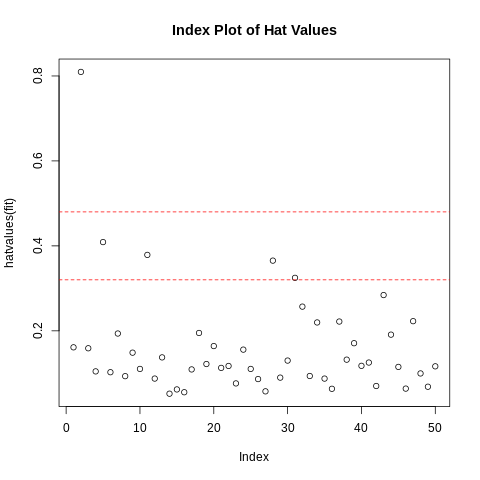

In [13]:
%%R
hat.plot(linear_model)

*Влиятельные наблюдения*

Влиятельные наблюдения – это наблюдения, которые оказывают непропорционально
большое влияние на значения параметров модели. Существуют два метода обнаружения влиятельных наблюдений: расстояние Кука (или $D-$
статистика) и диаграммы добавленных переменных.

Значения расстояния Кука, превышающие $4/(n – k – 1)$, где $n$ – объем выборки, а $k$ – число независимых переменных, свидетельствуют о влиятельных наблюдениях.

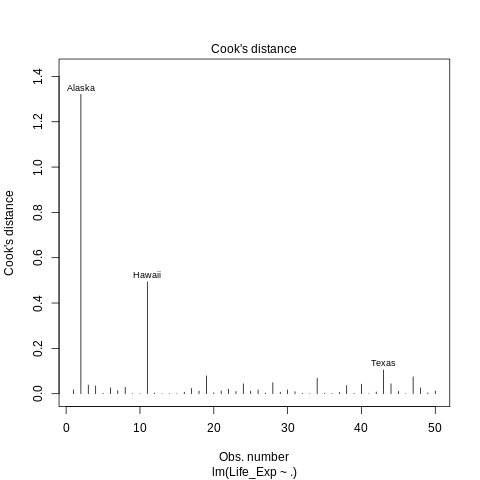

In [14]:
%%R
cutoff <- 4/((nrow(df)-length(linear_model$coefficients)-2))
plot(linear_model, which=4, cook.levels=cutoff)

Для одной зависимой и $k$ независимых переменных создается $k$ диаграмм добавленных переменных.

Для каждой независимой переменной $X_k$ отображаются остатки от регрессии зависимой переменной по остальным $k – 1$ независимым переменным. Диаграммы добавленных переменных строятся при помощи функции avPlots() из пакета {car}

Прямая на каждой диаграмме – это регрессионный коэффициент для данной независимой переменной. Вклад влиятельных наблюдений можно оценить, если представить, как изменится линия, если удалить точку, соответствующую
данному наблюдению.

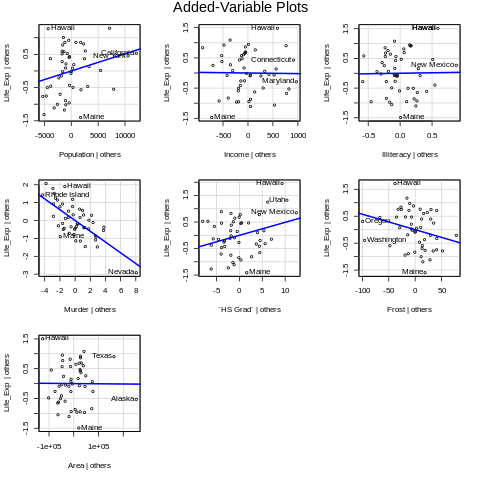

In [15]:
%%R

avPlots(linear_model)


Можно свести информацию о выбросах, точках с высокой напряженностью и влиятельных наблюдениях на одну диаграмму при помощи функции influencePlot() из пакета {car}

              StudRes       Hat       CookD
Alaska     -1.6061632 0.8095223 1.320803928
California -0.1590567 0.4088569 0.002239186
Hawaii      2.7352416 0.3787617 0.493948906
Maine      -2.2322062 0.1218190 0.078915835


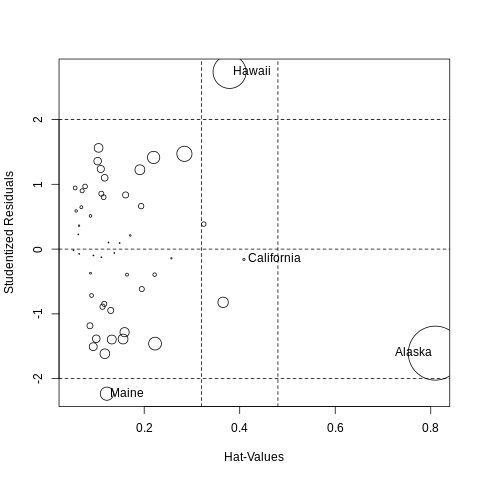

In [16]:
%%R

influencePlot(linear_model)

**Сравнение моделей**

Информационный критерий Акаике (Akaike Information Criterion, AIC). При расчете этого критерия учитывается статистическое соответствие модели данным и число необходимых для достижения этого соответствия параметров. Предпочтение нужно отдавать моделям с меньшими значениями AIC, указывающими на хорошее соответствие данным при использовании меньшего числа параметров. Этот
критерий вычисляется при помощи функции AIC()

In [17]:
%%R
model_1 <- lm(Life_Exp ~ Population + Income, df)
model_2 <- lm(Life_Exp ~ Population + Income + Frost, df)
AIC(model_1, model_2)

        df      AIC
model_1  4 171.0234
model_2  5 171.7832


**Выбор лучшей модели**

1. Пошаговая регрессия

При пошаговом выборе переменные добавляются в модель или удаляются из нее по одной, пока не будет достигнуто заданное значение критерия для остановки процесса.

При методе пошагового включения (forward stepwise) переменные по одной добавляются в модель, пока добавление новых переменных не перестанет ее улучшать.

При пошаговом исключении (backward stepwise) начинают с модели, включающей все независимые переменные, а потом удаляют их по одной до тех пор, пока модель не начнет ухудшаться.

При комбинированном методе (stepwise stepwise) совмещены оба подхода. Переменные добавляются по одной, однако на каждом шаге происходит переоценка модели, и те переменные, которые не вносят значительного вклада, удаляются.

Результат применения метода пошаговой регрессии зависит от критериев включения или удаления переменных. При помощи функции stepAIC() из пакета MASS можно провести все три типа пошаговой регрессии с использованием точного критерия AIC.

In [18]:
%%R
step_model <- stepAIC(linear_model, direction = "both")

Start:  AIC=-22.18
Life_Exp ~ Population + Income + Illiteracy + Murder + `HS Grad` + 
    Frost + Area

             Df Sum of Sq    RSS     AIC
- Area        1    0.0011 23.298 -24.182
- Income      1    0.0044 23.302 -24.175
- Illiteracy  1    0.0047 23.302 -24.174
<none>                    23.297 -22.185
- Population  1    1.7472 25.044 -20.569
- Frost       1    1.8466 25.144 -20.371
- `HS Grad`   1    2.4413 25.738 -19.202
- Murder      1   23.1411 46.438  10.305

Step:  AIC=-24.18
Life_Exp ~ Population + Income + Illiteracy + Murder + `HS Grad` + 
    Frost

             Df Sum of Sq    RSS     AIC
- Illiteracy  1    0.0038 23.302 -26.174
- Income      1    0.0059 23.304 -26.170
<none>                    23.298 -24.182
- Population  1    1.7599 25.058 -22.541
+ Area        1    0.0011 23.297 -22.185
- Frost       1    2.0488 25.347 -21.968
- `HS Grad`   1    2.9804 26.279 -20.163
- Murder      1   26.2721 49.570  11.569

Step:  AIC=-26.17
Life_Exp ~ Population + Income + Murder 

Пошаговая регрессия – спорный подход. Хотя с его помощью можно найти хорошую модель, нет гарантии, что она будет лучшей, поскольку не рассмотрены все возможные модели. Попытка обойти это ограничение делается при использовании регрессии по всем подмножествам.

2. Регрессия по всем подмножествам

В ходе регрессии по всем подмножествам исследуются все возможные модели. Регрессия по всем подмножествам проводится при помощи функции regsubsets() из пакета {leaps}. 
В качестве критерия «лучшей» модели можно выбрать коэффициент детерминации, скорректированный коэффициент детерминации или Cp-статистику Мэллоуса (Mallows Cp statistic).

Коэффициент детерминации – это доля дисперсии зависимой переменной, объясненная независимыми переменными.

Скорректированный коэффициент детерминации учитывает число параметров модели.

Статистика Мэллоуса также используется в качестве критерия «лучшей» модели. Считается, что для хорошей модели эта статистика должна принимать значения, близкие к числу па-раметров модели (включая свободный член).

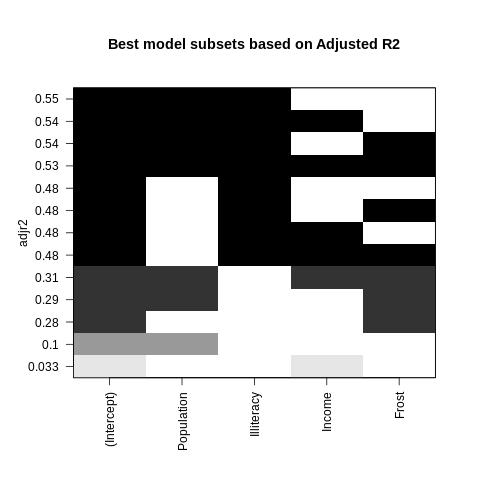

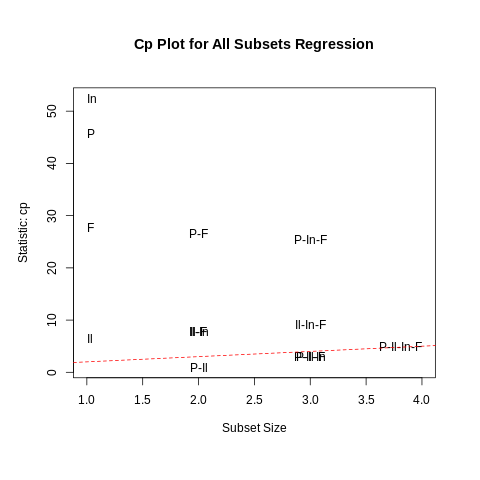

In [21]:
%%R

leaps <-regsubsets(Murder ~ Population + Illiteracy + Income +
                   Frost, data=df, nbest=4)
plot(leaps, scale="adjr2", 
     main="Best model subsets based on Adjusted R2")


subsets(leaps, statistic="cp", legend=TRUE, # legend is placed interactively
         main="Cp Plot for All Subsets Regression") 
abline(1,1,lty=2,col="red")

3. Кросс-валидация

Насколько хорошо полученное уравнение работает в реальном мире?

При кросс-валидации часть данных используется как обучающая выборка, а часть – как тестовая. Регрессионное уравнение подгоняется для обучающей выборки, а затем применяется для проверочной.

При $k$-кратной кросс-валидации выборка разделяется на $k$ подвыборок. Каждая из них играет роль тестовой выборки, а объединенные данные оставшихся $k – 1$ подвыборок используются как обучающая группа. Применимость $k$ уравнений к $k$ тестовым выборкам фиксируется и затем усредняется. Если $k = n$ (общему числу наблюдений), то такой подход называется оценкой по методу «складного ножа» (последовательного исключения значений выборки с возвратом – jackknifing).

Выполнить $k$-кратную кросс-валидацию можно при помощи функции crossval() из пакета {bootstrap}.

In [23]:
%%R
shrinkage <- function(fit,k=10){
require(bootstrap)
# define functions 
theta.fit <- function(x,y){lsfit(x,y)}
theta.predict <- function(fit,x){cbind(1,x)%*%fit$coef} 

# matrix of predictors
x <- fit$model[,2:ncol(fit$model)]
# vector of predicted values
y <- fit$model[,1]

results <- crossval(x,y,theta.fit,theta.predict,ngroup=k)
r2 <- cor(y, fit$fitted.values)**2 # raw R2 
r2cv <- cor(y,results$cv.fit)**2 # cross-validated R2
cat("Original R-square =", r2, "\n")
cat(k, "Fold Cross-Validated R-square =", r2cv, "\n")
cat("Change =", r2-r2cv, "\n")
}

In [24]:
%%R
shrinkage(linear_model)

Original R-square = 0.7361563 
10 Fold Cross-Validated R-square = 0.5232263 
Change = 0.21293 


**Линейные модели с регуляризацией**

Простая линейная регрессионная модель, в которой мы пытаемся предсказать $n$ наблюдений переменной отклика, $Y$, с помощью линейной комбинации $m$ переменных-предсказателей, $X$, и нормально распределенной ошибки с дисперсией $\sigma^2$:
$$Y = βX + ɛ, \quad ɛ ~ N(0,σ^2).$$

Поскольку мы не знаем истинных параметров $\beta$ мы должны оценить их по выборке. В подходе МНК мы оцениваем их как $\hat\beta$ таким образом, чтобы сумма квадратов остатков была как можно меньше. Другими словами, мы минимизируем следующую функцию потерь:

$$L(\hat{β})=\sum\limits_{i=1}^n (y_i - x_i \hat{\beta})^2 = ||y - X\hat{\beta}||^2,$$

чтобы получить оценки параметров  $\hat\beta_{\text{МНК}} = (X'X)^{-1}(X'Y)$.

В статистике необходимо учитывать две важнейшие характеристики оценок: смещение и дисперсию. Смещение - это разница между истинным параметром и ожидаемой оценкой 
$$ Bias(\hat{\beta}_{МНК}) = E(\hat{\beta}_{МНК}) - \beta. $$

Смещение измеряет точность оценок. Дисперсия, с другой стороны, измеряет разброс, или неопределенность, в этих оценках. Она определяется следующим образом

$$Var(\hat{\beta}_{МНК}) = \sigma^2(X'X)^{-1},$$

где неизвестная дисперсия ошибки $\sigma^2$ может быть оценена по остаткам как

$$\hat{\sigma}^2 = \dfrac{e'e}{n-m}, \quad e = y- X\hat{\beta}. $$

Этот график иллюстрирует, что такое смещение и дисперсия. Представьте, что "яблочко" - это истинный параметр популяции, который мы оцениваем, $β$, а выстрелы в него - это значения наших оценок, полученные в результате применения четырех различных оценок - с низкой погрешностью и дисперсией, с высокой погрешностью и дисперсией, а также их комбинаций.

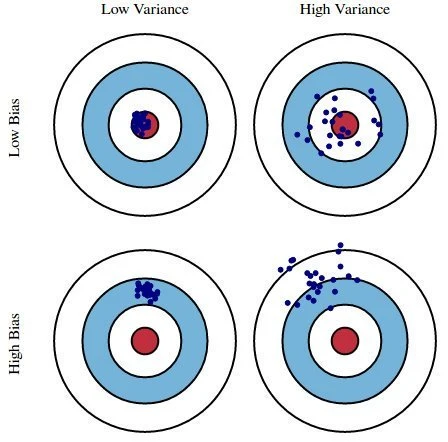

И смещение, и дисперсия должны быть низкими, так как большие значения приводят к плохому прогнозу модели. Фактически, ошибка модели может быть разложена на три части: ошибка, возникающая из-за большой дисперсии, ошибка, возникающая из-за значительного смещения, и остаток - необъяснимая часть:

$$E(e) = (E(X\hat{β}) - X\beta)^2 + E(X\hat{\beta} - E(X\hat{\beta}))^2 + σ^2 = Bias^2 + Variance + \sigma^2. $$



Оценки МНК обладают желаемым свойством несмещенности. Однако они могут иметь огромную дисперсию. В частности, это происходит, когда:
* переменные-предикторы сильно коррелируют друг с другом;
* имеется много предикторов. Это отражено в формуле для дисперсии, приведенной выше: если $m$ приближается к $n$, дисперсия приближается к бесконечности.

Общее решение этой проблемы таково: уменьшить дисперсию ценой внесения некоторой погрешности. Такой подход называется регуляризацией и почти всегда благоприятно сказывается на предсказательной эффективности модели. 
По мере увеличения сложности модели, которую в случае линейной регрессии можно представить как количество предикторов, дисперсия оценок также увеличивается, но смещение уменьшается. 


**Ridge регрессия (гребневая регрессия)**

Удаление предикторов из модели можно рассматривать как установку их коэффициентов в ноль. Вместо того чтобы заставлять их быть точно нулевыми, давайте наказывать их, если они слишком далеки от нуля, тем самым заставляя их быть маленькими непрерывным образом. Таким образом, мы уменьшаем сложность модели, сохраняя все переменные в модели. В принципе, это и есть то, что делает Ridge Regression.

В гребневой регрессии функция потерь МНК дополняется таким образом, что мы не только минимизируем сумму квадратов остатков, но и штрафуем размер оценок параметров, чтобы сжать их к нулю:

$$L(\hat{β})=\sum\limits_{i=1}^n (y_i - x_i' \hat{\beta})^2 + \lambda \sum\limits_{i=1}^n \hat{\beta_j}^2 = ||y - X\hat{\beta}||^2 + \lambda ||\hat{\beta}||^2.$$

Решение этой задачи для $\hat\beta$ дает оценки гребневой регрессии $\hat\beta_{ridge} = (X'X+\lambda I)^{-1}(X'Y)$, где $I$ обозначает единичную матрицу.

Параметр $\lambda$ - это штраф за регуляризацию. Заметим следующее: при $\lambda \rightarrow 0, \quad \hat\beta_{ridge} \rightarrow \hat\beta_{\text{МНК}}$,   а при $\lambda \rightarrow \infty, \quad \hat\beta_{ridge} \rightarrow 0$.

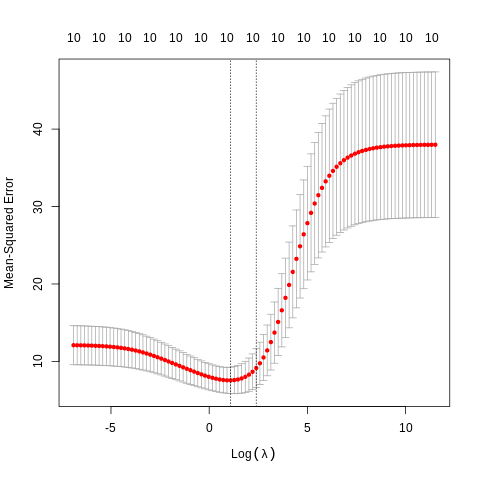

In [25]:
%%R
set.seed(123)    # seef for reproducibility
library(glmnet)  # for ridge regression
library(dplyr)   # for data cleaning
library(psych)   # for function tr() to compute trace of a matrix

data("mtcars")
# Center y, X will be standardized in the modelling function
y <- mtcars %>% select(mpg) %>% scale(center = TRUE, scale = FALSE) %>% as.matrix()
X <- mtcars %>% select(-mpg) %>% as.matrix()


# Perform 10-fold cross-validation to select lambda ---------------------------
lambdas_to_try <- 10^seq(-3, 5, length.out = 100)
# Setting alpha = 0 implements ridge regression
ridge_cv <- cv.glmnet(X, y, alpha = 0, lambda = lambdas_to_try,
                      standardize = TRUE, nfolds = 10)
# Plot cross-validation results
plot(ridge_cv)

In [29]:
%%R

# Best cross-validated lambda
lambda_cv <- ridge_cv$lambda.min
# Fit final model, get its sum of squared residuals and multiple R-squared
model_cv <- glmnet(X, y, alpha = 0, lambda = lambda_cv, standardize = TRUE)
y_hat_cv <- predict(model_cv, X)
ssr_cv <- t(y - y_hat_cv) %*% (y - y_hat_cv)
rsq_ridge_cv <- cor(y, y_hat_cv)[1,1]^2

rsq_ridge_cv

[1] 0.8524086


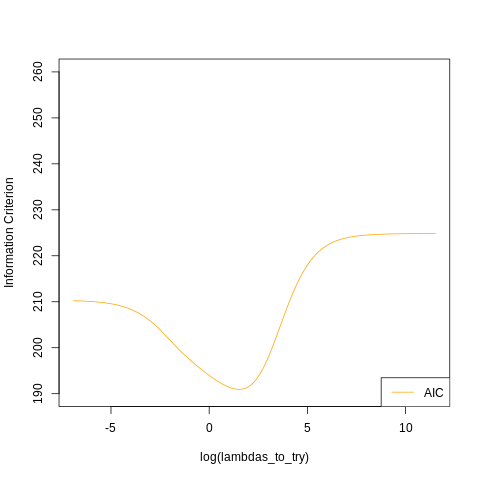

In [30]:
%%R

# Best cross-validated lambda
lambda_cv <- ridge_cv$lambda.min
# Fit final model, get its sum of squared residuals and multiple R-squared
model_cv <- glmnet(X, y, alpha = 0, lambda = lambda_cv, standardize = TRUE)
y_hat_cv <- predict(model_cv, X)
ssr_cv <- t(y - y_hat_cv) %*% (y - y_hat_cv)
rsq_ridge_cv <- cor(y, y_hat_cv)^2


# Use information criteria to select lambda -----------------------------------
X_scaled <- scale(X)
aic <- c()
for (lambda in seq(lambdas_to_try)) {
  # Run model
  model <- glmnet(X, y, alpha = 0, lambda = lambdas_to_try[lambda], standardize = TRUE)
  # Extract coefficients and residuals (remove first row for the intercept)
  betas <- as.vector((as.matrix(coef(model))[-1, ]))
  resid <- y - (X_scaled %*% betas)
  # Compute hat-matrix and degrees of freedom
  ld <- lambdas_to_try[lambda] * diag(ncol(X_scaled))
  H <- X_scaled %*% solve(t(X_scaled) %*% X_scaled + ld) %*% t(X_scaled)
  df <- tr(H)
  # Compute information criteria
  aic[lambda] <- nrow(X_scaled) * log(t(resid) %*% resid) + 2 * df
}

# Plot information criteria against tried values of lambdas
plot(log(lambdas_to_try), aic, col = "orange", type = "l",
     ylim = c(190, 260), ylab = "Information Criterion")
legend("bottomright", lwd = 1, col = c("orange"), legend = c("AIC"))

          s0
mpg 0.849631


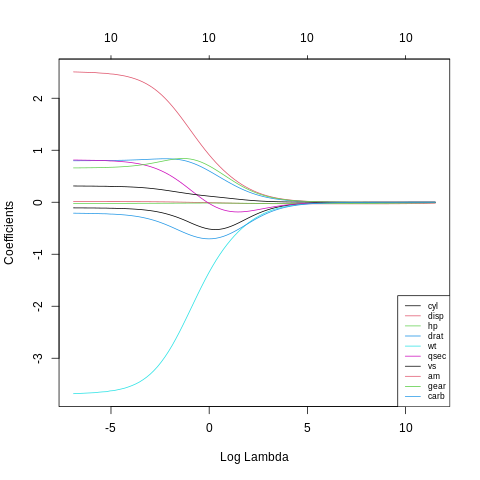

In [32]:
%%R

# Optimal lambdas according to both criteria
lambda_aic <- lambdas_to_try[which.min(aic)]

# Fit final models, get their sum of squared residuals and multiple R-squared
model_aic <- glmnet(X, y, alpha = 0, lambda = lambda_aic, standardize = TRUE)
y_hat_aic <- predict(model_aic, X)
ssr_aic <- t(y - y_hat_aic) %*% (y - y_hat_aic)
rsq_ridge_aic <- cor(y, y_hat_aic)^2

print(rsq_ridge_aic)
# See how increasing lambda shrinks the coefficients --------------------------
# Each line shows coefficients for one variables, for different lambdas.
# The higher the lambda, the more the coefficients are shrinked towards zero.
res <- glmnet(X, y, alpha = 0, lambda = lambdas_to_try, standardize = FALSE)
plot(res, xvar = "lambda")
legend("bottomright", lwd = 1, col = 1:6, legend = colnames(X), cex = .7)

**Lasso регрессия**

Lasso (Least Absolute Shrinkage and Selection Operator) концептуально очень похож на гребневую регрессию. Так же добавляется штраф за ненулевые коэффициенты, но в отличие от гребневой регрессии, которая наказывает сумму квадратов коэффициентов (так называемый штраф L2), лассо наказывает сумму их абсолютных значений (штраф L1). В результате, при больших значениях $λ$ многие коэффициенты точно обнуляются при лассо, чего никогда не происходит при гребневой регрессии.

Единственное различие в функциях потерь ridge и lasso заключается в штрафных терминах. При лассо потери определяются как:

$$L(\hat{β})=\sum\limits_{i=1}^n (y_i - x_i' \hat{\beta})^2 + \lambda \sum\limits_{i=1}^n |\hat{\beta_j}| = |y - X\hat{\beta}|^2 + \lambda |\hat{\beta}|.$$

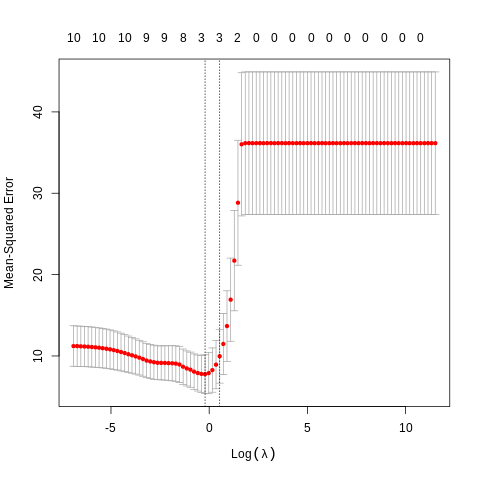

In [33]:
%%R

# Perform 10-fold cross-validation to select lambda ---------------------------
lambdas_to_try <- 10^seq(-3, 5, length.out = 100)
# Setting alpha = 1 implements lasso regression
lasso_cv <- cv.glmnet(X, y, alpha = 1, lambda = lambdas_to_try,
                      standardize = TRUE, nfolds = 10)
# Plot cross-validation results
plot(lasso_cv)

           s0
mpg 0.8424217


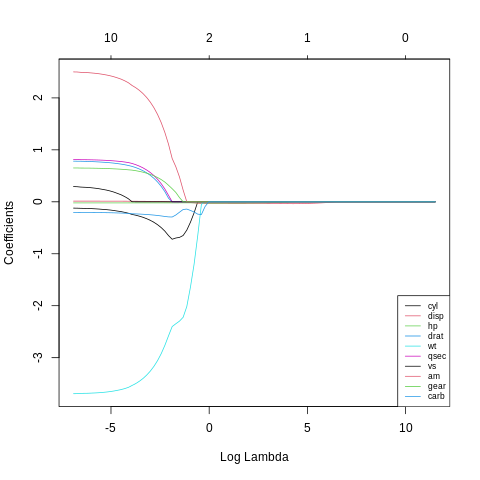

In [35]:
%%R

# Best cross-validated lambda
lambda_cv <- lasso_cv$lambda.min
# Fit final model, get its sum of squared residuals and multiple R-squared
model_cv <- glmnet(X, y, alpha = 1, lambda = lambda_cv, standardize = TRUE)
y_hat_cv <- predict(model_cv, X)
ssr_cv <- t(y - y_hat_cv) %*% (y - y_hat_cv)
rsq_lasso_cv <- cor(y, y_hat_cv)^2
print(rsq_lasso_cv)


# See how increasing lambda shrinks the coefficients --------------------------
# Each line shows coefficients for one variables, for different lambdas.
# The higher the lambda, the more the coefficients are shrinked towards zero.
res <- glmnet(X, y, alpha = 1, lambda = lambdas_to_try, standardize = FALSE)
plot(res, xvar = "lambda")
legend("bottomright", lwd = 1, col = 1:6, legend = colnames(X), cex = .7)

**Elastic Net**

Модель Elastic Net впервые появилась в результате критики лассо, выбор переменных которого может быть слишком зависим от данных и, следовательно, нестабилен. Решение состоит в том, чтобы объединить штрафы гребневой регрессии и лассо, чтобы получить лучшее из двух миров. Целью Elastic Net является минимизация следующей функции потерь:

$$
L_{enet}(\hat{β}) = \dfrac{\sum\limits_{i=1}^n (y_i - x'_i \hat{\beta})^2}{2n} + \lambda (\dfrac{1-\alpha}{2} \sum\limits_{j=1}^m \hat{\beta}_j^2 + \alpha \sum\limits_{j=1}^m |\hat{\beta}_j|  ),
$$

где $\alpha$ - параметр смешивания между риджем ($\alpha = 0$) и лассо ($\alpha = 1$).

Теперь необходимо настроить два параметра $\lambda$ и $\alpha$. Пакет glmnet позволяет настроить $\lambda$ с помощью кросс-валидации для фиксированного $\alpha$, но он не поддерживает настройку $\alpha$.

In [36]:
%%R

# Set training control
train_control <- trainControl(method = "repeatedcv",
                              number = 5,
                              repeats = 5,
                              search = "random",
                              verboseIter = TRUE)

# Train the model
elastic_net_model <- train(mpg ~ .,
                           data = cbind(y, X),
                           method = "glmnet",
                           preProcess = c("center", "scale"),
                           tuneLength = 25,
                           trControl = train_control)

# Check multiple R-squared
y_hat_enet <- predict(elastic_net_model, X)
rsq_enet <- cor(y, y_hat_enet)^2
rsq_enet

+ Fold1.Rep1: alpha=0.78229, lambda=0.017429 
- Fold1.Rep1: alpha=0.78229, lambda=0.017429 
+ Fold1.Rep1: alpha=0.09359, lambda=0.015629 
- Fold1.Rep1: alpha=0.09359, lambda=0.015629 
+ Fold1.Rep1: alpha=0.46678, lambda=0.007075 
- Fold1.Rep1: alpha=0.46678, lambda=0.007075 
+ Fold1.Rep1: alpha=0.51151, lambda=0.027268 
- Fold1.Rep1: alpha=0.51151, lambda=0.027268 
+ Fold1.Rep1: alpha=0.59999, lambda=6.939586 
- Fold1.Rep1: alpha=0.59999, lambda=6.939586 
+ Fold1.Rep1: alpha=0.33282, lambda=0.003919 
- Fold1.Rep1: alpha=0.33282, lambda=0.003919 
+ Fold1.Rep1: alpha=0.48861, lambda=0.002218 
- Fold1.Rep1: alpha=0.48861, lambda=0.002218 
+ Fold1.Rep1: alpha=0.95447, lambda=0.003508 
- Fold1.Rep1: alpha=0.95447, lambda=0.003508 
+ Fold1.Rep1: alpha=0.48290, lambda=0.489741 
- Fold1.Rep1: alpha=0.48290, lambda=0.489741 
+ Fold1.Rep1: alpha=0.89035, lambda=0.258876 
- Fold1.Rep1: alpha=0.89035, lambda=0.258876 
+ Fold1.Rep1: alpha=0.91444, lambda=3.006580 
- Fold1.Rep1: alpha=0.91444, lambd